# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or Chapter 4 of the code repo if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file. 

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.*


***
##  Task 1: SEE THE BIG PICTURE (5 pts)
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

In [0]:
# Import some common packages
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

data = pd.read_csv("insurance.csv")
print((data.memory_usage(index = True).sum() * 0.000001), "MB")
print(data.shape[0], "entries")
print(data.shape[1], "features")
print(data.dtypes)
print("3 categorical variables")
print(data.isnull().sum())
print("No missing values")

print(data.info())

print(data.describe())
print(data.describe(include = ["object"]))

0.07500799999999999 MB
1338 entries
7 features
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
3 categorical variables
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
No missing values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min  

---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING (25 pts)

**Data Discover:** Plot out all correlations among the features. You may notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class. 

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf781df4e0>,
      dtype=object)

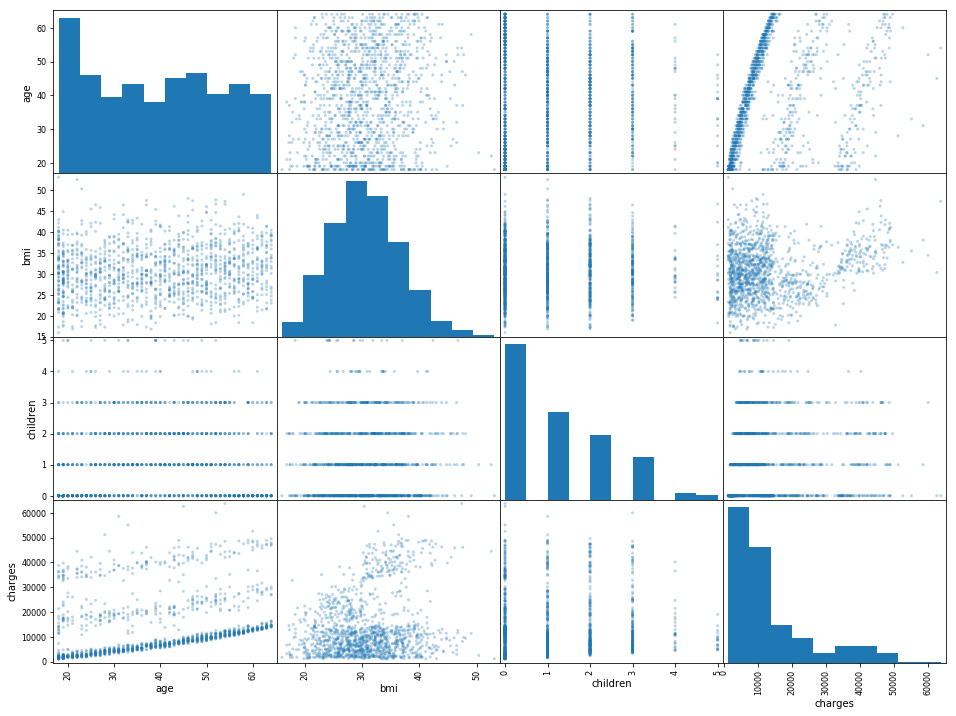

In [0]:
from pandas.plotting import scatter_matrix

print(data.corr())

scatter_matrix(data, figsize = (16, 12), alpha = 0.3)

In [0]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import *
from sklearn.compose import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
    ("std_scaler", StandardScaler())
])

#num_attributes = ["age", "bmi", "children"]
#cat_attributes = ["sex", "smoker", "region"]
num_attributes = [0, 2, 3]
cat_attributes = [1, 4, 5]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", OneHotEncoder(), cat_attributes)
])


# check if preparing before train/test split
# split first, pipeline on train
train_set, test_set = train_test_split(data, 
                                       test_size = 0.2, 
                                       random_state = 42)

X_train = train_set.drop("charges", axis = 1)
y_train = train_set["charges"].copy()
X_test = test_set.drop("charges", axis = 1)
y_test = test_set["charges"].copy()
X_train = full_pipeline.fit_transform(X_train)
print(y_train.shape)

(1070,)


- - -
## Task 3. IMPLEMENT GRADIENT DESCENT (30 pts)
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods. 

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [0]:
# NOTE: You may not use the library Linear Regression, but implement your own!

class MyLinearRegression():

  def __init__ (self):
    self.theta = (np.ones((12, 1))) # parameter vector
    self.alpha = 0.3 # learning rate
    self.cost  = 0 # cost function

  def gradientDescent(self, X_train, y_train, theta, alpha, iters = 100):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT: 
    theta: updated value for theta
    cost: value of the cost function
    """
    m = X_train.shape[0]
    cost_list = []
    for iteration in range(iters):
      middle = X_train.dot(theta)
      middle2 = middle - y_train
      gradients = 2/m * X_train.T.dot(middle2)
      theta = theta - self.alpha * gradients
      
      # calcualte cost
      self.cost = (X_train.dot(theta) - y_train)**2
      cost_list.append(self.cost)

    return theta, cost_list


  def fitUsingGradientDescent(self, X_train, y_train):
    """
    Train the regressor using gradient descent
    """    
    y = y_train.to_numpy()
    y = np.reshape(y, (-1, 1))

    X_copy = X_train.copy()
    X_copy = np.c_[np.ones((X_copy.shape[0], 1)), X_copy]

    t, cost_list = self.gradientDescent(X_train = X_copy, y_train = y, 
                        theta = self.theta, alpha = self.alpha)
    self.theta = t
    return cost_list

  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    y = y_train.to_numpy()
    y = np.reshape(y, (-1, 1))

    X_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    theta_best = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    self.theta = theta_best

  def predict(self, X_test):
    """
    Predicting the label
    """
    X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]
    y_predict = np.matmul(X_test, self.theta)
    return y_predict

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    print("Parameter vector is ")
    print(self.theta)
    return ""
    
myGradientDescentModel = MyLinearRegression()
print(X_train.shape)
print(y_train.shape)
cost_list = myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)  
print(myGradientDescentModel)

(1070, 11)
(1070,)
Parameter vector is 
[[ 9026.74573813]
 [ 3614.97545464]
 [ 2036.22784873]
 [  516.8902809 ]
 [ 4523.16865192]
 [ 4504.57708622]
 [-7311.69126456]
 [16339.4370027 ]
 [ 2717.02140902]
 [ 2346.34338653]
 [ 2059.15867846]
 [ 1907.22226412]]



* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

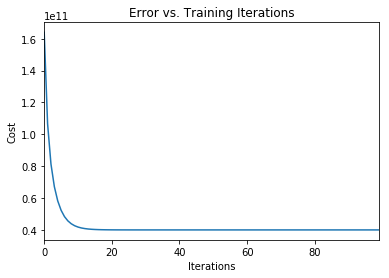

In [0]:
# iters and cost must be supplied to plot out the cost function
%matplotlib inline

plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations')
sum_array = [np.sum(a) for a in cost_list]
sum_array = np.array(sum_array).tolist()
ser = pd.Series(sum_array)
ser.plot.line()

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION (10 pts)

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement: 

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [0]:
\myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)

- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS (20 pts)

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you may also use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [0]:
from sklearn.metrics import mean_squared_error

X_test = full_pipeline.transform(X_test)

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(X_train,y_train)
y_predict = mySGDModel.predict(X_test)
mse = mean_squared_error(y_test, y_predict)
mySGDModel_rmse = np.sqrt(mse)
print("SGDRegressor: ", mySGDModel_rmse)

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, lin_pred)
lin_rmse = np.sqrt(mse_lin)
print("Linear Regression: ", lin_rmse)

myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)
y_predict_gd = myGradientDescentModel.predict(X_test)
mse_gd = mean_squared_error(y_test, y_predict_gd)
gd_rmse = np.sqrt(mse_gd)
print("My gradient descent: ", gd_rmse)

myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)
y_predict_ne = myNormalEquationModel.predict(X_test)
mse_ne = mean_squared_error(y_test, y_predict_ne)
ne_rmse = np.sqrt(mse_ne)
print("My normal equation: ", ne_rmse)

SGDRegressor:  5800.369541261692
Linear Regression:  5796.2846592762735
My gradient descent:  5796.284771973671
My normal equation:  5796.284659276274
